In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import os
from scipy.stats import ttest_ind,norm
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.simplefilter('ignore')

In [3]:
c2c=pd.read_csv('cell2cell.csv')
c2c['calibrat'].value_counts()

1    40000
0    31047
Name: calibrat, dtype: int64

In [4]:
c2c_train=c2c[c2c['calibrat']==1]
c2c_train=c2c_train.drop('churndep',axis=1)
c2c_test=c2c[c2c['calibrat']==0]
c2c_test=c2c_test.drop('churndep',axis=1)

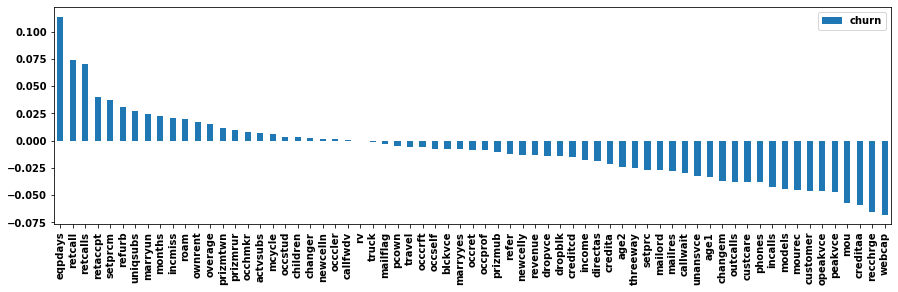

In [5]:
#check correlation bewtween churn and other veriable
corr_matrix = c2c_train.corr()
corr_matrix.sort_values('churn',ascending=False,inplace=True)
corr_matrix=corr_matrix.loc[:, ['churn']]
corr_matrix.drop(['churn','calibrat'], inplace=True)
corr_matrix.plot(kind='bar',figsize=(15,4))

In [6]:
c2c_train.dropna(how='any',inplace=True)
x_train=c2c_train.drop(['customer','calibrat','churn'],axis=1)
y_train=c2c_train['churn'] 
c2c_test.dropna(how='any',inplace=True)
x_test=c2c_test.drop(['customer','calibrat','churn'],axis=1)
y_test=c2c_test['churn'] 
y_train.value_counts()

0    19543
1    19398
Name: churn, dtype: int64

In [7]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(x_train, y_train)
pre = clf.predict(x_test)

C:\Users\ryosu\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


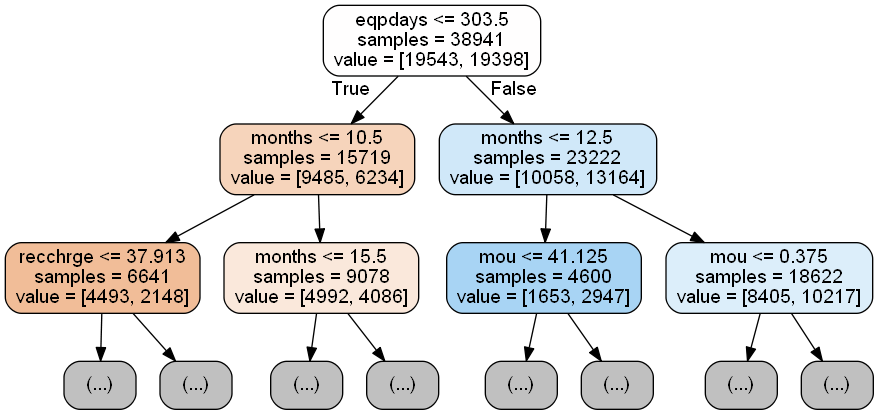

In [8]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython import display
from sklearn import tree
from IPython.display import Image
from graphviz import Digraph
from sklearn.externals.six import StringIO

dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,feature_names=x_train.columns,max_depth=2, filled=True, rounded=True, impurity=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
display.display(display.Image(graph.create_png()))

In [9]:
print((19398/38941)*100)
print((2148/6641)*100)
print((4086/9078)*100)
print((2947/4600)*100)
print((10217/18622)*100)

49.81382090855397
32.34452642674296
45.00991407799075
64.06521739130436
54.86521318870153


In [10]:
x_train=sm.add_constant(x_train)
logit = sm.Logit(y_train, x_train)
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.671533
         Iterations 5


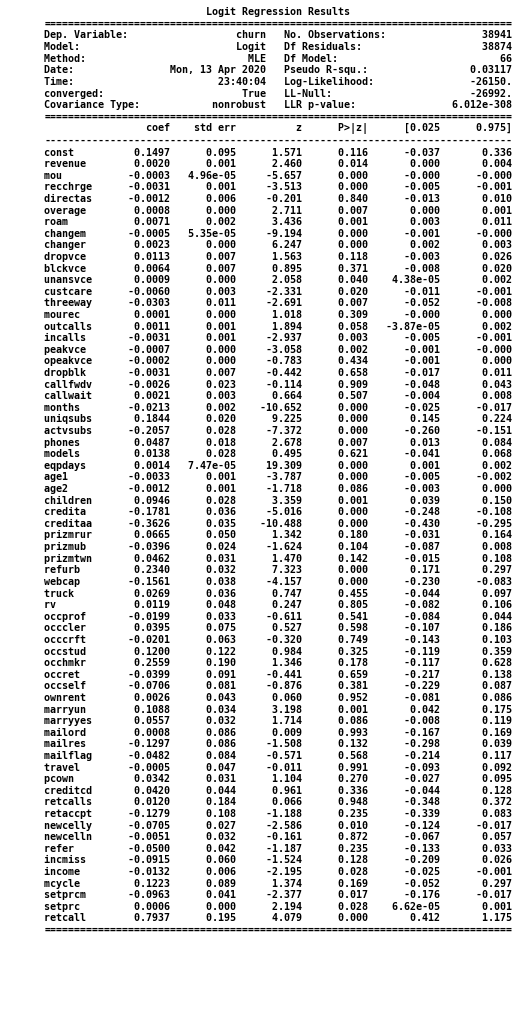

In [11]:
summary=result.summary()
fig,ax= plt.subplots(figsize=(7,10))
ax.axis('off')
ax.axis('tight')
plt.text(0.01, 0.05, str(summary), {'fontsize': 15}, fontproperties = 'monospace') 
plt.savefig('output.png')

In [12]:
def odds_ratios(result_logit):
 odds=np.exp(result_logit.params[1:])
 se=np.exp(result_logit.params[1:])*result_logit.bse[1:]
 z=abs(odds-1)/se
 pvals=np.round(norm.sf(z)*2*1000)/1000
 lconf=odds-1.94*se
 rconf=odds+1.94*se
 return pd.DataFrame({'Odds ratios': odds, 'std err': se, 'z': z, 'P>|z|': pvals, '[0.025': lconf, '0.975]': rconf},index=result_logit.params.keys()[1:])

In [13]:
x_test=sm.add_constant(x_test)
pre_logit_prob =result.predict(x_test)
pre_logit =(result.predict(x_test)>0.5)*1
from sklearn import datasets, model_selection, metrics
co_mat_logit = metrics.confusion_matrix(y_test, pre_logit)
print('confusion matrix:')
print(co_mat_logit)
cl_repo_logit = metrics.classification_report(y_test, pre_logit)
print('classification report:')
print(cl_repo_logit)

confusion matrix:
[[17905 11877]
 [  247   339]]
classification report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75     29782
           1       0.03      0.58      0.05       586

    accuracy                           0.60     30368
   macro avg       0.51      0.59      0.40     30368
weighted avg       0.97      0.60      0.73     30368



In [14]:
a=odds_ratios(result)
b=x_train.describe().T
b.drop('const',inplace=True)
ab=pd.concat([a,b], axis=1)
ab['normalized']=(ab['Odds ratios']**ab['std'])
ab['abs']=abs(1-ab['normalized'])
ab.sort_values('abs',ascending=False, inplace=True)
ab=ab[ab['abs']>=0.1]
ab.drop('dropvce')
print(ab.T.columns)
ab

Index(['eqpdays', 'uniqsubs', 'months', 'retcall', 'mou', 'actvsubs',
       'changem', 'creditaa', 'dropvce'],
      dtype='object')


,Odds ratios,std err,z,P>|z|,[0.025,0.975],count,mean,std,min,25%,50%,75%,max,normalized,abs
eqpdays,1.001,0.000,19.295,0.000,1.001,1.002,38941.000,392.283,255.199,-5.000,212.000,342.000,532.000,1823.000,1.445,0.445
uniqsubs,1.202,0.024,8.425,0.000,1.156,1.249,38941.000,1.548,1.319,1.000,1.000,1.000,2.000,196.000,1.275,0.275
months,0.979,0.002,10.766,0.000,0.975,0.983,38941.000,18.802,9.562,6.000,11.000,17.000,24.000,61.000,0.816,0.184
retcall,2.212,0.430,2.815,0.005,1.377,3.046,38941.000,0.038,0.192,0.000,0.000,0.000,0.000,1.000,1.164,0.164
mou,1.000,0.000,5.658,0.000,1.000,1.000,38941.000,513.345,523.483,0.000,151.750,356.500,701.250,7667.750,0.863,0.137
actvsubs,0.814,0.023,8.185,0.000,0.770,0.858,38941.000,1.356,0.678,0.000,1.000,1.000,2.000,53.000,0.870,0.130
changem,1.000,0.000,9.196,0.000,0.999,1.000,38941.000,-14.944,258.296,-2867.500,-87.000,-6.250,62.750,5192.250,0.881,0.119
creditaa,0.696,0.024,12.641,0.000,0.649,0.743,38941.000,0.118,0.322,0.000,0.000,0.000,0.000,1.000,0.890,0.110
dropvce,1.011,0.007,1.554,0.120,0.997,1.026,38941.000,5.939,8.862,0.000,0.667,3.000,7.667,221.667,1.106,0.106


In [15]:
#Based on the decision tree graph, create a new variable with eqpdays>=303.5 and month <=12.5
c2c['eq_mon']=((c2c['eqpdays']>303.5)&(c2c['months']<=12.5))*1

In [16]:
features1=['calibrat','churn','eqpdays', 'uniqsubs', 'months', 'retcall', 'mou', 'actvsubs',
       'changem', 'creditaa', 'eq_mon']

In [17]:
c2c1=c2c[features1]
c2c1.dropna(how='any',inplace=True)
c2c_train1=c2c1[c2c1['calibrat']==1]
c2c_test1=c2c1[c2c1['calibrat']==0]
x_train1=c2c_train1.drop(['calibrat','churn'],axis=1)
y_train1=c2c_train1['churn']
x_test1=c2c_test1.drop(['calibrat','churn'],axis=1)
y_test1=c2c_test1['churn']

In [18]:
x_train1=sm.add_constant(x_train1)
logit1 = sm.Logit(y_train1, x_train1)
result1=logit1.fit()

Optimization terminated successfully.
         Current function value: 0.673825
         Iterations 5


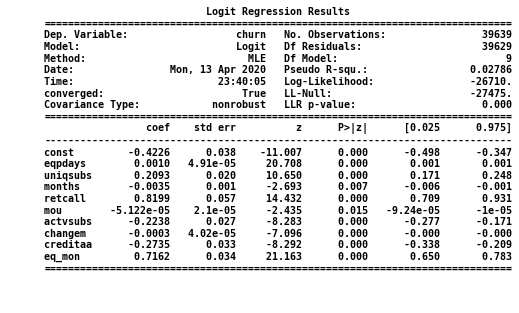

In [19]:
summary=result1.summary()
fig,ax= plt.subplots(figsize=(7,5))
ax.axis('off')
ax.axis('tight')
plt.text(0.01, 0.05, str(summary), {'fontsize': 15}, fontproperties = 'monospace') 
plt.savefig('output1.png')

In [20]:
odds_ratios(result1)

,Odds ratios,std err,z,P>|z|,[0.025,0.975]
eqpdays,1.001,0.000,20.697,0.000,1.001,1.001
uniqsubs,1.233,0.024,9.610,0.000,1.186,1.280
months,0.997,0.001,2.698,0.007,0.994,0.999
retcall,2.270,0.129,9.849,0.000,2.020,2.520
mou,1.000,0.000,2.435,0.015,1.000,1.000
actvsubs,0.799,0.022,9.283,0.000,0.758,0.841
changem,1.000,0.000,7.097,0.000,1.000,1.000
creditaa,0.761,0.025,9.536,0.000,0.712,0.809
eq_mon,2.047,0.069,15.111,0.000,1.912,2.181


In [21]:
c=odds_ratios(result1)
d=x_train1.describe().T
d.drop('const',inplace=True)
cd=pd.concat([c,d], axis=1)
cd['normalized']=(cd['Odds ratios']**cd['std'])
cd['abs']=abs(1-cd['normalized'])
cd.sort_values('abs',ascending=False, inplace=True)
cd

,Odds ratios,std err,z,P>|z|,[0.025,0.975],count,mean,std,min,25%,50%,75%,max,normalized,abs
uniqsubs,1.233,0.024,9.610,0.000,1.186,1.280,39639.000,1.550,1.317,1.000,1.000,1.000,2.000,196.000,1.318,0.318
eqpdays,1.001,0.000,20.697,0.000,1.001,1.001,39639.000,391.305,254.972,-5.000,212.000,341.000,530.000,1823.000,1.296,0.296
eq_mon,2.047,0.069,15.111,0.000,1.912,2.181,39639.000,0.119,0.323,0.000,0.000,0.000,0.000,1.000,1.261,0.261
retcall,2.270,0.129,9.849,0.000,2.020,2.520,39639.000,0.038,0.191,0.000,0.000,0.000,0.000,1.000,1.170,0.170
actvsubs,0.799,0.022,9.283,0.000,0.758,0.841,39639.000,1.358,0.685,0.000,1.000,1.000,2.000,53.000,0.858,0.142
creditaa,0.761,0.025,9.536,0.000,0.712,0.809,39639.000,0.118,0.322,0.000,0.000,0.000,0.000,1.000,0.916,0.084
changem,1.000,0.000,7.097,0.000,1.000,1.000,39639.000,-15.007,259.647,-2867.500,-87.500,-6.250,63.000,5192.250,0.929,0.071
months,0.997,0.001,2.698,0.007,0.994,0.999,39639.000,18.771,9.575,6.000,11.000,16.000,24.000,61.000,0.967,0.033
mou,1.000,0.000,2.435,0.015,1.000,1.000,39639.000,514.811,524.942,0.000,152.000,357.500,703.500,7667.750,0.973,0.027


In [22]:
x_test1=sm.add_constant(x_test1)
pre_logit_prob1=result1.predict(x_test1)
pre_logit1 =(result1.predict(x_test1)>0.5)*1
co_mat_logit1 = metrics.confusion_matrix(y_test1, pre_logit1)
print('confusion matrix:')
print(co_mat_logit1)
cl_repo_logit1 = metrics.classification_report(y_test1, pre_logit1)
print('classification report:')
print(cl_repo_logit1)

confusion matrix:
[[19660 10645]
 [  280   320]]
classification report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78     30305
           1       0.03      0.53      0.06       600

    accuracy                           0.65     30905
   macro avg       0.51      0.59      0.42     30905
weighted avg       0.97      0.65      0.77     30905



In [23]:
import mba263
logit_gains=mba263.gain(c2c_test['churn'],pre_logit_prob,bins=30)
logit1_gains=mba263.gain(c2c_test1['churn'],pre_logit_prob1,bins=30)

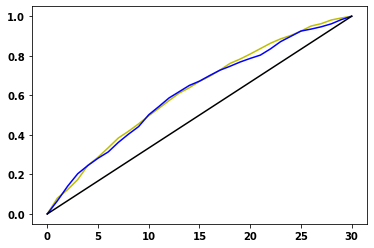

In [24]:
plt.plot(logit_gains,'y')
plt.plot(logit1_gains,'b')
plt.plot([0,30],[0,1],'k')

hmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm, donno lol
->since eqp_mon dummy indicate people who has been using orifinal phone for the long time, the company can give them promotion to buy new phone so that they don't go other company.

In [25]:
a=c2c[['churn','months']].groupby('months').mean()
a[a['churn']>=(a['churn'].mean())*1.2]

,churn
months,
11,0.441
12,0.398
13,0.336
20,0.332
58,0.357
61,0.500


In [26]:
c2c[['churn','months']].groupby('months').describe()

churn                                          
          count  mean   std   min   25%   50%   75%   max
months                                                   
6       994.000 0.197 0.398 0.000 0.000 0.000 0.000 1.000
7      3974.000 0.164 0.370 0.000 0.000 0.000 0.000 1.000
8      3061.000 0.159 0.366 0.000 0.000 0.000 0.000 1.000
9      3411.000 0.151 0.358 0.000 0.000 0.000 0.000 1.000
10     3299.000 0.219 0.414 0.000 0.000 0.000 0.000 1.000
11     5012.000 0.441 0.497 0.000 0.000 0.000 1.000 1.000
12     3824.000 0.398 0.490 0.000 0.000 0.000 1.000 1.000
13     3794.000 0.336 0.473 0.000 0.000 0.000 1.000 1.000
14     3176.000 0.327 0.469 0.000 0.000 0.000 1.000 1.000
15     2650.000 0.311 0.463 0.000 0.000 0.000 1.000 1.000
16     2515.000 0.299 0.458 0.000 0.000 0.000 1.000 1.000
17     2440.000 0.304 0.460 0.000 0.000 0.000 1.000 1.000
18     2111.000 0.299 0.458 0.000 0.000 0.000 1.000 1.000
19     2779.000 0.289 0.453 0.000 0.000 0.000 1.000 1.000
20     1996.000 0.332 0.471 0.000 0.000 0.000 1.000 1.000
21     2528.000 0.286 0.452 0.000 0.000 0.000 1.000 1.000
22     1761.000 0.289 0.453 0.000 0.000 0.000 1.000 1.000
23     2532.000 0.309 0.462 0.000 0.000 0.000 1.000 1.000
24     1625.000 0.305 0.460 0.000 0.000 0.000 1.000 1.000
25     2242.000 0.291 0.454 0.000 0.000 0.000 1.000 1.000
26     1400.000 0.302 0.459 0.000 0.000 0.000 1.000 1.000
27     1292.000 0.286 0.452 0.000 0.000 0.000 1.000 1.000
28     1068.000 0.307 0.462 0.000 0.000 0.000 1.000 1.000
29     1250.000 0.290 0.454 0.000 0.000 0.000 1.000 1.000
30      947.000 0.313 0.464 0.000 0.000 0.000 1.000 1.000
31     1214.000 0.280 0.449 0.000 0.000 0.000 1.000 1.000
32      826.000 0.322 0.468 0.000 0.000 0.000 1.000 1.000
33     1000.000 0.288 0.453 0.000 0.000 0.000 1.000 1.000
34      734.000 0.305 0.461 0.000 0.000 0.000 1.000 1.000
35      900.000 0.264 0.441 0.000 0.000 0.000 1.000 1.000
36      590.000 0.276 0.448 0.000 0.000 0.000 1.000 1.000
37      663.000 0.299 0.458 0.000 0.000 0.000 1.000 1.000
38      410.000 0.278 0.449 0.000 0.000 0.000 1.000 1.000
39      363.000 0.287 0.453 0.000 0.000 0.000 1.000 1.000
40      239.000 0.268 0.444 0.000 0.000 0.000 1.000 1.000
41      299.000 0.298 0.458 0.000 0.000 0.000 1.000 1.000
42      195.000 0.272 0.446 0.000 0.000 0.000 1.000 1.000
43      238.000 0.227 0.420 0.000 0.000 0.000 0.000 1.000
44      191.000 0.293 0.456 0.000 0.000 0.000 1.000 1.000
45      196.000 0.240 0.428 0.000 0.000 0.000 0.000 1.000
46      158.000 0.266 0.443 0.000 0.000 0.000 1.000 1.000
47      187.000 0.278 0.449 0.000 0.000 0.000 1.000 1.000
48      160.000 0.275 0.448 0.000 0.000 0.000 1.000 1.000
49      157.000 0.261 0.441 0.000 0.000 0.000 1.000 1.000
50      128.000 0.312 0.465 0.000 0.000 0.000 1.000 1.000
51       88.000 0.318 0.468 0.000 0.000 0.000 1.000 1.000
52       78.000 0.256 0.439 0.000 0.000 0.000 0.750 1.000
53      112.000 0.196 0.399 0.000 0.000 0.000 0.000 1.000
54       64.000 0.250 0.436 0.000 0.000 0.000 0.250 1.000
55       53.000 0.245 0.434 0.000 0.000 0.000 0.000 1.000
56       31.000 0.194 0.402 0.000 0.000 0.000 0.000 1.000
57       35.000 0.086 0.284 0.000 0.000 0.000 0.000 1.000
58       14.000 0.357 0.497 0.000 0.000 0.000 1.000 1.000
59       31.000 0.065 0.250 0.000 0.000 0.000 0.000 1.000
60       10.000 0.200 0.422 0.000 0.000 0.000 0.000 1.000
61        2.000 0.500 0.707 0.000 0.250 0.500 0.750 1.000

In [27]:
c2c['changem'].describe()

count   70545.000
mean      -10.846
std       255.314
min     -3875.000
25%       -83.000
50%        -5.000
75%        65.750
max      5192.250
Name: changem, dtype: float64

In [28]:
c2c['changer'].describe()

count   70545.000
mean       -1.206
std        38.770
min     -1107.740
25%        -7.108
50%        -0.295
75%         1.605
max      2483.482
Name: changer, dtype: float64

In [29]:
 # a variable to identify too much subscriptions. high number means they have too much subscritions 
c2c['uq-ac']=c2c['uniqsubs']-c2c['actvsubs']
# a variables to identify inappropriate plan. if it's - then, they are revenue goes up or unchanged but minutes went down. the other way is
c2c['changem_chenger']=c2c['changem']*c2c['changer'] 
# first year approaching dummy
c2c['renew1']=((c2c['months']==11)|(c2c['months']==12))*1
# 20 month dummy. seems like some of loan contract for a cell phone is 20month
c2c['20months']=(c2c['months']==20)*1

In [40]:
features2=['calibrat','churn', 'months', 'retcall', 'mou','changem', 'creditaa', 'uq-ac','changem_chenger','renew1','20months']
c2c2=c2c[features2]
c2c2.dropna(how='any',inplace=True)
c2c_train2=c2c2[c2c2['calibrat']==1]
c2c_test2=c2c2[c2c2['calibrat']==0]
x_train2=c2c_train2.drop(['calibrat','churn'],axis=1)
y_train2=c2c_train2['churn']
x_test2=c2c_test2.drop(['calibrat','churn'],axis=1)
y_test2=c2c_test2['churn']

30906

In [31]:
x_train2=sm.add_constant(x_train2)
logit2 = sm.Logit(y_train2, x_train2)
result2=logit2.fit()

Optimization terminated successfully.
         Current function value: 0.676944
         Iterations 6


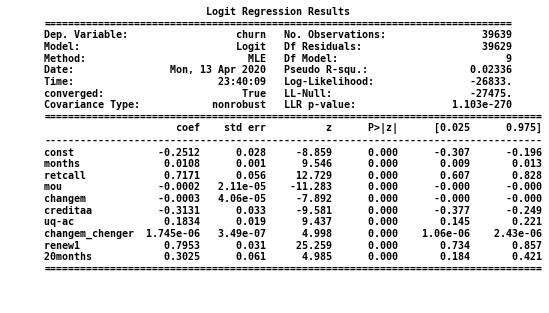

In [32]:
summary2=result2.summary()
fig,ax= plt.subplots(figsize=(7,5))
ax.axis('off')
ax.axis('tight')
plt.text(0.01, 0.05, str(summary2), {'fontsize': 15}, fontproperties = 'monospace') 
plt.savefig('output2.png')

In [33]:
odds_ratios(result2)

,Odds ratios,std err,z,P>|z|,[0.025,0.975]
months,1.011,0.001,9.495,0.000,1.009,1.013
retcall,2.048,0.115,9.085,0.000,1.825,2.272
mou,1.000,0.000,11.285,0.000,1.000,1.000
changem,1.000,0.000,7.893,0.000,1.000,1.000
creditaa,0.731,0.024,11.250,0.000,0.685,0.778
uq-ac,1.201,0.023,8.622,0.000,1.156,1.247
changem_chenger,1.000,0.000,4.998,0.000,1.000,1.000
renew1,2.215,0.070,17.422,0.000,2.080,2.350
20months,1.353,0.082,4.302,0.000,1.194,1.512


In [36]:
e=odds_ratios(result2)
f=x_train2.describe().T
f.drop('const',inplace=True)
ef=pd.concat([e,f], axis=1)
ef['normalized']=(ef['Odds ratios']**ef['std'])
ef['abs']=abs(1-ef['normalized'])
ef.sort_values('abs',ascending=False, inplace=True)
ef

,Odds ratios,std err,z,P>|z|,[0.025,0.975],count,mean,std,min,25%,50%,75%,max,normalized,abs
renew1,2.215,0.070,17.422,0.000,2.080,2.350,39639.000,0.143,0.350,0.000,0.000,0.000,0.000,1.000,1.321,0.321
uq-ac,1.201,0.023,8.622,0.000,1.156,1.247,39639.000,0.192,0.900,0.000,0.000,0.000,0.000,143.000,1.179,0.179
retcall,2.048,0.115,9.085,0.000,1.825,2.272,39639.000,0.038,0.191,0.000,0.000,0.000,0.000,1.000,1.147,0.147
changem_chenger,1.000,0.000,4.998,0.000,1.000,1.000,39639.000,6377.320,74987.217,-266467.280,0.000,59.513,1713.042,12894861.491,1.140,0.140
mou,1.000,0.000,11.285,0.000,1.000,1.000,39639.000,514.811,524.942,0.000,152.000,357.500,703.500,7667.750,0.883,0.117
months,1.011,0.001,9.495,0.000,1.009,1.013,39639.000,18.771,9.575,6.000,11.000,16.000,24.000,61.000,1.109,0.109
creditaa,0.731,0.024,11.250,0.000,0.685,0.778,39639.000,0.118,0.322,0.000,0.000,0.000,0.000,1.000,0.904,0.096
changem,1.000,0.000,7.893,0.000,1.000,1.000,39639.000,-15.007,259.647,-2867.500,-87.500,-6.250,63.000,5192.250,0.920,0.080
20months,1.353,0.082,4.302,0.000,1.194,1.512,39639.000,0.029,0.168,0.000,0.000,0.000,0.000,1.000,1.052,0.052


In [42]:
x_test2=sm.add_constant(x_test2)
pre_logit_prob2=result2.predict(x_test2)
pre_logit2 =(result2.predict(x_test2)>0.5)*1
co_mat_logit2= metrics.confusion_matrix(y_test2, pre_logit2)
print('confusion matrix:')
print(co_mat_logit2)
cl_repo_logit2 = metrics.classification_report(y_test2, pre_logit2)
print('classification report:')
print(cl_repo_logit2)

confusion matrix:
[[20665  9641]
 [  336   264]]
classification report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.81     30306
           1       0.03      0.44      0.05       600

    accuracy                           0.68     30906
   macro avg       0.51      0.56      0.43     30906
weighted avg       0.97      0.68      0.79     30906



In [43]:
c2c['revenue'].mean()

58.852802928784534